In [165]:
import numpy as np
from sklearn.datasets import load_iris, make_blobs, load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from utils import *

# Number of classes
nn = 2

# dataset_name = "digit_0_2"

# X = load_iris().data[:,:2]
# y = load_iris()['target']

# n_samples = 3*40
# X, y = make_blobs(n_samples=160, centers=nn, random_state=42)

digits = load_digits(n_class=nn)
X, y = digits.data, digits.target

# Data preprocessing using standard scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dimensionality reduction
tsne = PCA(n_components=2)
X = tsne.fit_transform(X_scaled)

# Initialize the lists to hold the split data
X_train_list = []
X_test_list = []
y_train_list = []
y_test_list = []

# Splitting the data
for i in range(nn):
    # Filter the data for the current class
    X_class = X[y == i]
    y_class = y[y == i]
    
    # Perform the split
    X_class_train, X_class_test, y_class_train, y_class_test = train_test_split(
        X_class, y_class, test_size=70, train_size=50, random_state=151
    )
    
    # Append the current class's split to the lists
    X_train_list.append(X_class_train)
    X_test_list.append(X_class_test)
    y_train_list.append(y_class_train)
    y_test_list.append(y_class_test)

# Concatenate all class splits together
X_train = np.concatenate(X_train_list)
X_test = np.concatenate(X_test_list)
y_train = np.concatenate(y_train_list)
y_test = np.concatenate(y_test_list)

print(f'Dataset split summary:')
print(f'Training set size: {X_train.shape[0]}')
print(f'Testing set size: {X_test.shape[0]}')

def signii(y):
    return np.where(y > 0, 1, -1)

Dataset split summary:
Training set size: 100
Testing set size: 140


Creating the QUBO of size (200, 200)
intercept :  -10593.198279297789
Test accuracy: 0.92
Train accuracy: 0.92


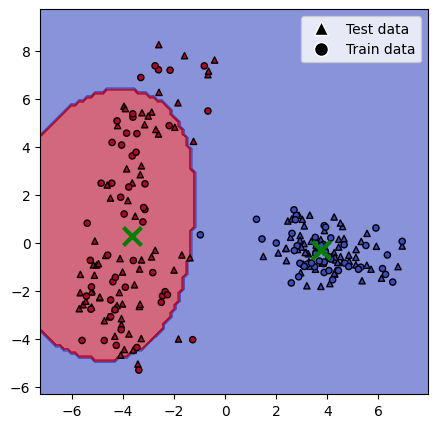

In [178]:
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_curve, auc
from neal import SimulatedAnnealingSampler as SA

class qsvm:
    """Quantum Support Vector Machine (QSVM) classifier"""

    def __init__(self, B=2, K=2, Xi=1, gamma=0.1, C=1, kernel='rbf', optimizer = SA, num_reads=1000):
        self.B = B  # Base of the qubit representation (default: 2).
        self.K = K  # Number of qubits per alpha (default: 2).
        self.Xi = Xi  # Regularization parameter for the QUBO (default: 1).
        self.gamma = gamma  # Kernel coefficient for the RBF kernel (default: 0.1).
        self.C = C  # Penalty parameter of the error term (default: 1).
        self.kernel = kernel # Kernel function ('rbf' for now, can be extended) (default: 'rbf').
        self.classes_ = None
        self.optimizer = optimizer # QUBO optimizer
        self.num_reads = num_reads # Number of samples to generate during QUBO solving (default: 1000).
        
        # Attributes for storing model parameters and results
        self.support_vectors = None # Support vectors identified during training.
        self.alphas = None # Lagrange multipliers for the support vectors.
        self.support_labels = None # Labels of the support vectors.
        self.intercept = None # Intercept of the hyperplane.
        self.energy = None  # Energy of the best QUBO solution found during training.

    def rbf_kernel(self, X, Y):
        """Calculates the Radial Basis Function (RBF) kernel matrix."""
        XX = np.atleast_2d(X)
        YY = np.atleast_2d(Y)
        return np.exp(-self.gamma * np.sum((XX[:, np.newaxis] - YY[np.newaxis, :]) ** 2, axis=-1))
 
    def _make_qubo(self, X, y):
        """Constructs the Quadratic Unconstrained Binary Optimization (QUBO) problem."""
        N = X.shape[0]
        Q = np.zeros((self.K * N, self.K * N))
        print(f'Creating the QUBO of size {Q.shape}')
        for n in range(N):
            for m in range(N):
                for k in range(self.K):
                    for j in range(self.K):
                        Q[self.K * n + k, self.K * m + j] = (
                            0.5 * self.B**(k + j) * y[n] * y[m] * (self.rbf_kernel(X[n], X[m]) + self.Xi)
                            - (self.B**k if n == m and k == j else 0)
                            # + self.C * (y[n] * self.B**k)
                        )
                        
        Q = np.triu(Q) + np.tril(Q, -1).T  # Ensure symmetry and upper triangular form
        
        return Q
    
    def _decode(self, binary):
        """Decodes binary QUBO results into alpha values."""
        N = len(binary) // self.K
        Bvec = self.B ** np.arange(self.K)
        return (np.fromiter(binary, float).reshape(N, self.K) @ Bvec).flatten()

    def eval_offset(self, X, y):
        """Evaluates the offset (intercept) using strategies from Numerical Recipes."""

        if self.alphas is None or self.support_vectors is None:
            raise ValueError("The model has not been trained yet. Please call `fit` first.")
        
        K = self.rbf_kernel(X, self.support_vectors)
    
        # Calculate the average offset based on margin points
        b = np.sum(self.alphas * (self.C-self.alphas) * (self.support_labels - np.dot(K, self.alphas * self.support_labels))) / np.sum(self.alphas * (self.C-self.alphas))
        return b

        # # More robust offset calculation (Numerical Recipes approach)
        # # Sort f_values and corresponding labels
        # sorted_indices = np.argsort(f_values)
        # f_values_sorted = f_values[sorted_indices]
        # y_sorted = y[sorted_indices]

        # # Find candidate b values between consecutive f_values of opposite classes
        # class_changes = np.where(y_sorted[:-1] != y_sorted[1:])[0]

        # # Ensure at least two candidate intercepts
        # if len(class_changes) < 2:
        #     # If there's only one class change, add the average of the first and last f_values as a candidate
        #     b_candidates = [-(f_values_sorted[0] + f_values_sorted[-1]) / 2]
        # else:
        #     b_candidates = -(f_values_sorted[class_changes] + f_values_sorted[class_changes + 1]) / 2

        # # Choose the b that maximizes the number of correctly classified points
        # num_correct = [(y == self.signum(f_values + b)).sum() for b in b_candidates]
        # best_b_index = np.argmax(num_correct)
        # return b_candidates[best_b_index]

    def fit(self, X, y):
        """Trains the QSVM model by solving the QUBO and extracting support vectors."""
        # Input validation
        if not isinstance(X, np.ndarray):
            raise ValueError("Input features (X) must be a NumPy array.")
        if not isinstance(y, np.ndarray):
            raise ValueError("Target labels (y) must be a NumPy array.")
        if len(X) != len(y):
            raise ValueError("X and y must have the same number of samples.")
        y = y.astype(int)  # Ensure integer labels for QUBO calculation
        if np.unique(y).tolist() != [-1, 1]:
            raise ValueError("Labels (y) must contain only -1 and 1 values.")

        qubo = self._make_qubo(X, y)
        sampleset = self.optimizer().sample_qubo(qubo, num_reads=self.num_reads)
        sample = sampleset.first.sample

        alpha_real = self._decode(sample)
        
        support_indices = (alpha_real >= 1e-10) #  & (self.alphas <= self.C)
        self.support_vectors = X[support_indices]
        self.alphas = alpha_real[support_indices]
        self.support_labels = y[support_indices]
        
        self.intercept = self.eval_offset(X, y)
        print("intercept : ", self.intercept)
        
        self.energy = sampleset.first.energy  

    def predict(self, X):
        """Predicts labels for new data points."""
        K = self.rbf_kernel(X, self.support_vectors)
        scores = np.dot(K, self.alphas * self.support_labels) + self.intercept
        return np.sign(scores)

    def evaluate(self, X, y):
        """Evaluates the model's accuracy, AUROC, and AUPRC on given data."""
        score = self.predict(X)
        accuracy = accuracy_score(y, score)
        auroc = roc_auc_score(y, score)
        precision, recall, _ = precision_recall_curve(y, score)
        auprc = auc(recall, precision)
        return accuracy, auroc, auprc

# Create and train the QSVM classifier
sa_svm = qsvm(
    B = 2,
    K = 2,
    Xi = 1,
    gamma = 0.02,
    C = 1,
    optimizer = SA,
    num_reads = 100
    )

if __name__ == '__main__':
    sa_svm.fit(X_train, signii(y_train))

    # Evaluate the model's performance
    y_pred = sa_svm.predict(X_test)
    test_accuracy = accuracy_score(signii(y_test), y_pred)
    print(f"Test accuracy: {test_accuracy:.2f}")

    y_train_pred = sa_svm.predict(X_train)
    train_accuracy = accuracy_score(signii(y_train), y_train_pred)
    print(f"Train accuracy: {train_accuracy:.2f}")

    # y_accuracy, y_auroc, y_auprc = qsvm.evaluate(X_test, y_test)
    # print(y_accuracy, y_auroc, y_auprc)

    plot_figure(sa_svm, X, y, nn, X_test, X_train, y_test, y_train)

In [170]:
# gamma = 2 #Iris Petal
# gamma = 0.1 #Blob
gamma = 1 #Digit
C = 1

SVM training using SMO algorithm - START
Training summary: 3773 iterations, 57 support vectors
SVM training using SMO algorithm - DONE!
SVM training using SMO algorithm - START
Training summary: 3224 iterations, 56 support vectors
SVM training using SMO algorithm - DONE!
test accuracy :  100.0
train accuracy :  100.0


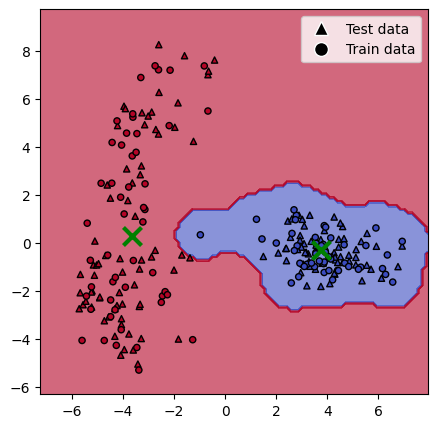

In [171]:
from sklearn.metrics import classification_report, accuracy_score
from smo_svm import smo_SVM, smo_OneVsAllClassifier

# Train Multiclass SVM on classic optimizer
smo_solver = smo_OneVsAllClassifier(
    solver=smo_SVM,
    num_classes=nn,
    c=C,
    kkt_thr=1e-4,
    max_iter=1e5,
    kernel_type='rbf',
    gamma_rbf=gamma
)

smo_solver.fit(X_train, y_train)

# Predict
y_pred = smo_solver.predict(X_test)
yt_pred= smo_solver.predict(X_train)

# Performance analysis
smo_test_accuracy = accuracy_score(y_test, y_pred)*100
smo_train_accuracy = accuracy_score(y_train, yt_pred)*100
print("test accuracy : ", smo_test_accuracy)
print("train accuracy : ", smo_train_accuracy)
# print(classification_report(y_test, y_pred))

plot_figure(smo_solver, X, y, nn, X_test, X_train, y_test, y_train) #, filename= "results\iris_SMO"

In [5]:
from sklearn.metrics import classification_report, accuracy_score
from sa_SVM import *

params = {
    "data": X_train,
    "label": y_train,
    "B": 2,
    "K": 2,
    "Xi": 1,
    "gamma": gamma,
    "C": C,
    "kernel": "rbf",
    "optimizer": "SA",
    "vis" : 0
}

sa_test = []
sa_train = []
NN = 3
for i in range(NN):
    # Initialize and train the classifier
    sa_OvR = OneVsRestClassifier(class_num=nn, classifier=qSVM, params=params)
    sa_OvR.solve(X_train, y_train)
    
    # Predict
    sa_predict = sa_OvR.predict(X_test)
    sa_t_pred= sa_OvR.predict(X_train)

    # Performance analysis
    sa_test_accuracy = accuracy_score(y_test, sa_predict)*100
    sa_training_accuracy = accuracy_score(y_train, sa_t_pred)*100

    sa_test.append(sa_test_accuracy)
    sa_train.append(sa_training_accuracy)

print("-------------------------")
print("SA")
print("train accuracy : ", sa_train)
# print("mean : ", np.mean(sa_train))
# print("standard deviation : ", np.std(sa_train))
print("test accuracy : ", sa_test)
# print(np.mean(sa_test))
# print(np.std(sa_test))
print("-------------------------")

# plot_figure(sa_OvR, X, y, nn, X_test, X_train, y_test, y_train) #, filename= f"results\{dataset_name}_SA1"
# print(classification_report(y_test, sa_predict))

Training classifier 0...
solving...
Creating the QUBO of size (200, 200)
Created the QUBO of size (200, 200)
K,N 2 100
self.intercept -0.04878374235426387
Training classifier 1...
solving...
Creating the QUBO of size (200, 200)
Created the QUBO of size (200, 200)
K,N 2 100
self.intercept -0.03879782702728036
Training classifier 2...
solving...
Creating the QUBO of size (200, 200)
Created the QUBO of size (200, 200)
K,N 2 100
self.intercept -0.02512020248493959
Training classifier 3...
solving...
Creating the QUBO of size (200, 200)
Created the QUBO of size (200, 200)
K,N 2 100
self.intercept -0.0060339745946712655
Training classifier 4...
solving...
Creating the QUBO of size (200, 200)
Created the QUBO of size (200, 200)
K,N 2 100
self.intercept -0.02959725677863902
-------------------------
SA
train accuracy :  [100.0, 100.0, 100.0, 100.0, 100.0]
test accuracy :  [61.5, 61.5, 61.5, 61.5, 61.5]
-------------------------


In [ ]:
from qsvm import *
from utils import *

NN = 1
mtqa_test = []
mtqa_train = []
qa_test = []
qa_train = []
for i in range(NN):
    params = {
        "data": X_train,
        "label": y_train,
        "B": 2,
        "K": 2,
        "Xi": 1,
        "gamma": gamma,
        "C": C,
        "kernel": "rbf",
        "optimizer": "MTQA",
        "qubo_list": None,
        "vis": 1
    }

    # Initialize and train the classifier
    mtqa_OvR = MTQA_OneVsRestClassifier(class_num=nn, classifier=qSVM, params=params)
    _, embedding_list, TotalQubo, Qubo_list = mtqa_OvR.solve(X_train, y_train)

    save_embedding(embedding_list, "iris_petal")
    save_TotalQubo(TotalQubo, "iris_petal")
    save_qubo_list(Qubo_list, "iris_petal")

    # Predict
    mtqa_predict = mtqa_OvR.predict(X_test)
    mtqa_t_pred= mtqa_OvR.predict(X_train)

    # Performance analysis
    mtqa_test_accuracy = accuracy_score(y_test, mtqa_predict)*100
    mtqa_training_accuracy = accuracy_score(y_train, mtqa_t_pred)*100

    mtqa_test.append(mtqa_test_accuracy)
    mtqa_train.append(mtqa_training_accuracy)

    qubo_list = load_qubo_list("iris_petal")
    emb = load_embedding("iris_petal")

    params = {
        "data": X_train,
        "label": y_train,
        "B": 2,
        "K": 2,
        "Xi": 1,
        "gamma": gamma,
        "C": C,
        "kernel": "rbf",
        "optimizer": "QA",
        "qubo_list" : qubo_list,
        "embeddings" : emb,
        "vis" : 1
    }

    # Initialize and train the classifier
    qa_OvR = OneVsRestClassifier(class_num=nn, classifier=qSVM, params=params)
    qa_OvR.solve(X_train, y_train)

    # Predict
    qa_predict = qa_OvR.predict(X_test)
    qa_t_pred= qa_OvR.predict(X_train)

    # Performance analysis
    qa_test_accuracy = accuracy_score(y_test, qa_predict)*100
    qa_training_accuracy = accuracy_score(y_train, qa_t_pred)*100

    qa_test.append(qa_test_accuracy)
    qa_train.append(qa_training_accuracy)

print("-------------------------")
print("QA")
print("train accuracy : ", qa_train)
print("mean : ", np.mean(qa_train))
print("standard deviation : ", np.std(qa_train))
print("test accuracy : ", qa_test)
print(np.mean(qa_test))
print(np.std(qa_test))

print("-------------------------")
print("MTQA")
print("train accuracy : ", mtqa_train)
print("mean : ", np.mean(mtqa_train))
print("standard deviation : ", np.std(mtqa_train))
print("test accuracy : ", mtqa_test)
print("mean : ",np.mean(mtqa_test))
print("standard deviation : ",np.std(mtqa_test))
print("-------------------------")

Training classifier 0...
solving...


C:\Users\happy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\matplotlib\cbook.py:1087: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


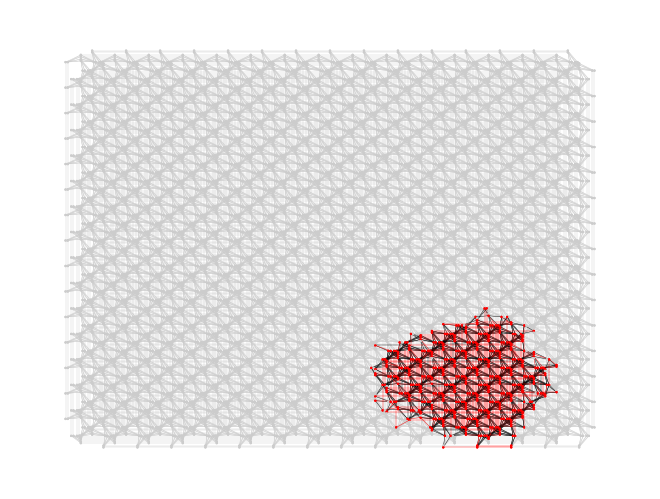

K,N 2 30
self.intercept -0.07729140294964619
Training classifier 1...
solving...


KeyboardInterrupt: 

In [15]:
from qsvm import *
from utils import *

params = {
    "data": X_train,
    "label": y_train,
    "B": 2,
    "K": 2,
    "Xi": 1,
    "gamma": gamma,
    "C": C,
    "kernel": "rbf",
    "optimizer": "QA",
    "vis" : 1
}

# Initialize and train the classifier
qa_OvR = OneVsRestClassifier(class_num=nn, classifier=qSVM, params=params)
qa_OvR.solve(X_train, y_train)

# Predict
qa_predict = qa_OvR.predict(X_test)
qa_t_pred= qa_OvR.predict(X_train)

# Performance analysis
qa_test = accuracy_score(y_test, qa_predict)*100
qa_train = accuracy_score(y_train, qa_t_pred)*100

print("-------------------------")
print("QA")
print("train accuracy : ", qa_train)
print("test accuracy : ", qa_test)
print("-------------------------")

In [ ]:
# dataset_name = "Blob4"
dataset_name = "digiiit"

plot_figure(smo_solver, X, y, nn, X_test, X_train, y_test, y_train, filename= f"results\{dataset_name}_SMO")
plot_figure(sa_OvR, X, y, nn, X_test, X_train, y_test, y_train, filename= f"results\{dataset_name}_SA")
# plot_figure(qa_OvR, X, y, nn, X_test, X_train, y_test, y_train, filename= f"results\{dataset_name}_QA")
# plot_figure(mtqa_OvR, X, y, nn, X_test, X_train, y_test, y_train, filename= f"results\{dataset_name}_MTQA")

In [ ]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def make_meshgrid(x, y, h=.2):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1    
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 80), np.linspace(y_min, y_max, 80))
    return xx, yy

# Function to plot decision boundaries
def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

# Set up plot figures
fig, sub = plt.subplots(1, 2,figsize=(16, 8))

# Create meshgrid
X0, X1 = X_tsne[:, 0], X_tsne[:, 1]
xx, yy = make_meshgrid(X0, X1)

# Define colormap for plotting
coolwarm = plt.cm.coolwarm
colors = coolwarm(np.linspace(0, 1, nn))
cm = ListedColormap(colors)

# Plot decision boundaries and data points for qSVM
ax = sub[0]
contour = plot_contours(ax, sa_one_vs_rest, xx, yy, cmap=cm, alpha=0.6)
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm, marker='^', edgecolors='k', s=20)
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm, marker='o', edgecolors='k', s=20)

# Compute and plot centroids
centroids = np.array([X_tsne[y == i].mean(axis=0) for i in np.unique(y)])
ax.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=169, linewidths=3, color='g', zorder=10)

ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(f"SA Decision Boundary Accuracy: {sa_test_accuracy:.2f}%")

# Add labels
labels = ['Test data', 'Train data']
handles = [plt.Line2D([0], [0], marker='^', color='white', markerfacecolor='k', markersize=10, linestyle=''),
           plt.Line2D([0], [0], marker='o', color='white', markerfacecolor='k', markersize=10, linestyle='')]
ax.legend(handles, labels)

# Plot decision boundaries and data points for classical SVM
ax = sub[1]
contour = plot_contours(ax, smo_solver, xx, yy, cmap=cm, alpha=0.6)
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm, marker='^', edgecolors='k', s=20)
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm, marker='o', edgecolors='k', s=20)

# Compute and plot centroids
centroids = np.array([X_tsne[y == i].mean(axis=0) for i in np.unique(y)])
ax.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=169, linewidths=3, color='g', zorder=10)

ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(f"Classic SVM Decision Boundary Accuracy: {smo_test_accuracy:.2f}%")

# Add labels
labels = ['Test data', 'Train data']
handles = [plt.Line2D([0], [0], marker='^', color='white', markerfacecolor='k', markersize=10, linestyle=''),
           plt.Line2D([0], [0], marker='o', color='white', markerfacecolor='k', markersize=10, linestyle='')]
ax.legend(handles, labels)

# Colorbar
# cbar = fig.colorbar(contour) #, ax=sub.ravel().tolist(), fraction=0.046, pad=0.04
# cbar.set_ticks(np.arange(0, nn))  # Setting ticks for nn classes
# cbar.set_ticklabels(np.arange(0, nn))  # Setting tick labels

plt.savefig("results\iris_SA_SMO.png",  bbox_inches='tight', dpi = 300)

plt.show()

In [ ]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def make_meshgrid(x, y, h=.2):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1    
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 80), np.linspace(y_min, y_max, 80))
    return xx, yy

# Function to plot decision boundaries
def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

# Set up plot figures
fig, sub = plt.subplots(1, 2,figsize=(16, 8))
plt.subplots_adjust(wspace=0.1, hspace=0.4)

# Create meshgrid
X0, X1 = X_tsne[:, 0], X_tsne[:, 1]
xx, yy = make_meshgrid(X0, X1)

# Define colormap for plotting
coolwarm = plt.cm.coolwarm
colors = coolwarm(np.linspace(0, 1, nn))
cm = ListedColormap(colors)

# Plot decision boundaries and data points for qSVM
ax = sub[0]
contour = plot_contours(ax, qa_OvR, xx, yy, cmap=cm, alpha=0.6)
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm, marker='^', edgecolors='k', s=20)
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm, marker='o', edgecolors='k', s=20)

# Compute and plot centroids
centroids = np.array([X_tsne[y == i].mean(axis=0) for i in np.unique(y)])
ax.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=169, linewidths=3, color='g', zorder=10)

ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(f"QA Decision Boundary Accuracy: {qa_test_accuracy*100:.2f}%")

# Add labels
labels = ['Test data', 'Train data']
handles = [plt.Line2D([0], [0], marker='^', color='white', markerfacecolor='k', markersize=10, linestyle=''),
           plt.Line2D([0], [0], marker='o', color='white', markerfacecolor='k', markersize=10, linestyle='')]
ax.legend(handles, labels)

# Plot decision boundaries and data points for classical SVM
ax = sub[1]
contour = plot_contours(ax, mtqa_OvR, xx, yy, cmap=cm, alpha=0.6)
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm, marker='^', edgecolors='k', s=20)
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm, marker='o', edgecolors='k', s=20)

# Compute and plot centroids
centroids = np.array([X_tsne[y == i].mean(axis=0) for i in np.unique(y)])
ax.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=169, linewidths=3, color='g', zorder=10)

ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(f"MTQA Decision Boundary Accuracy: {mtqa_test_accuracy*100:.2f}%")

# Add labels
labels = ['Test data', 'Train data']
handles = [plt.Line2D([0], [0], marker='^', color='white', markerfacecolor='k', markersize=10, linestyle=''),
           plt.Line2D([0], [0], marker='o', color='white', markerfacecolor='k', markersize=10, linestyle='')]
ax.legend(handles, labels)

# Colorbar
# cbar = fig.colorbar(contour) #, ax=sub.ravel().tolist(), fraction=0.046, pad=0.04
# cbar.set_ticks(np.arange(0, nn))  # Setting ticks for nn classes
# cbar.set_ticklabels(np.arange(0, nn))  # Setting tick labels

plt.savefig("results\iris_QA_MTQA.png",  bbox_inches='tight', dpi = 300)

plt.show()

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(y_test, svm_pred)
disp.figure_.suptitle("Classic SMO onfusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.savefig("results\iris_smo_confusion_matrix.png",  bbox_inches='tight', dpi = 300)

plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# First, predict the test set labels
qsvm_predictions = sa_one_vs_rest.predict(X_test)

# Now, compute the confusion matrix using sklearn's functionality
cm = confusion_matrix(y_test, qsvm_predictions)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(values_format='d')  # 'd' for integer formatting
plt.title("SA Confusion Matrix")

plt.savefig("results\iris_sa_confusion_matrix.png",  bbox_inches='tight', dpi = 300)

plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# First, predict the test set labels
qsvm_predictions = mtqa_OvR.predict(X_test)

# Now, compute the confusion matrix using sklearn's functionality
cm = confusion_matrix(y_test, qsvm_predictions)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(values_format='d')  # 'd' for integer formatting
plt.title("MTQA Confusion Matrix")

plt.savefig("results\iris_mtqa_confusion_matrix.png",  bbox_inches='tight', dpi = 300)

plt.show()


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# First, predict the test set labels
qsvm_predictions = qa_OvR.predict(X_test)

# Now, compute the confusion matrix using sklearn's functionality
cm = confusion_matrix(y_test, qsvm_predictions)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(values_format='d')  # 'd' for integer formatting
plt.title("QA Confusion Matrix")

plt.savefig("results\digit_0_3_qa_confusion_matrix.png",  bbox_inches='tight', dpi = 300)

plt.show()


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

# Initialize the classical SVM classifier
svm_classifier = SVC(kernel='rbf', gamma=gamma)

# Train the classifier
svm_classifier.fit(X_train, y_train)

# Evaluate the classifier
svm_pred = svm_classifier.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_pred)
print(f"Classical SVM Test Accuracy: {svm_accuracy*100:.2f}%")